# Disaster prediction using NLP

In [1]:
# uploading required files 
from google.colab import files 
a = files.upload()

Saving tweets.csv to tweets.csv


In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv("/content/tweets.csv")
data.sample()

,id,keyword,location,text,target
7952,7952,oil%20spill,NaN,Pipeline Fights Class Certification in Califor...,0


## Pre-processing data

In [4]:
# checking for null values 
data.isnull().sum()

id             0
keyword        0
location    3418
text           0
target         0
dtype: int64

In [5]:
data.shape

(11370, 5)

In [7]:
# imputing the missing values using fillna method
data['location'].fillna(method='bfill', inplace=True)
np.where(data.isnull())

(array([11369]), array([2]))

In [8]:
data['location'].fillna(method='ffill', inplace=True)
data.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [9]:
data.sample(6)

,id,keyword,location,text,target
6457,6457,hijack,#FreeAssange,2. US interference in Iranian air defense read...,0
4062,4062,detonate,"Florida, USA","So you would have to detonate 6,150,000,000 (y...",0
10710,10710,violent%20storm,Arizona,"""Once Upon a Time in the West"", Monument Valle...",0
6447,6447,hijack,Israel,How does the Left hijack a Presidential Electi...,0
311,311,annihilation,From The US Resides in the UK,NEW ANNIHILATION 🔥 ft TRAGEDY KHADAFI ⭐️P SWAY...,0
2144,2144,catastrophic,"York, England",But it eventually will have to work without......,0


In [12]:
columns = []
for i in data.columns:
  columns.append(i)

columns

['id', 'keyword', 'location', 'text', 'target']

In [13]:
# label encoding the categorical columns
from sklearn.preprocessing import LabelEncoder
data['keyword'] = LabelEncoder().fit_transform(data['keyword'])
data['location'] = LabelEncoder().fit_transform(data['location'])

data.tail()

,id,keyword,location,text,target
11365,11365,218,482,Media should have warned us well in advance. T...,0
11366,11366,218,3735,i feel directly attacked 💀 i consider moonbin ...,0
11367,11367,218,4462,i feel directly attacked 💀 i consider moonbin ...,0
11368,11368,218,3746,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0
11369,11369,218,3746,Jake Corway wrecked while running 14th at IRP.,1


## Visualization

In [14]:
true_disaster = []
false_disaster = []

for i in data['target']:
  if i == 1:
    true_disaster.append(i)
  else:
    false_disaster.append(i)

print("% of true disaster tweets =", round((len(true_disaster)/len(data['target']))*100,2))
print("% of false disaster tweets =", round((len(false_disaster)/len(data['target']))*100,2))

% of true disaster tweets = 18.59
% of false disaster tweets = 81.41


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<BarContainer object of 2114 artists>

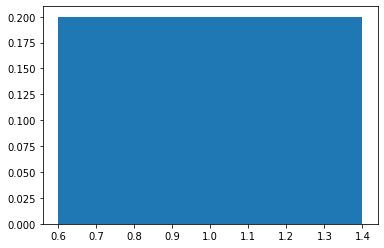

In [17]:
plt.bar(x=true_disaster, height=0.2)

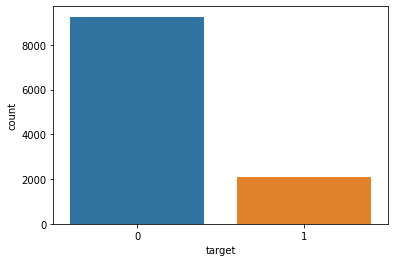

In [19]:
sns.countplot(x='target', data=data)

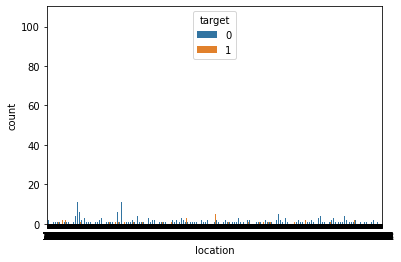

In [20]:
sns.countplot(x='location', hue='target', data=data)

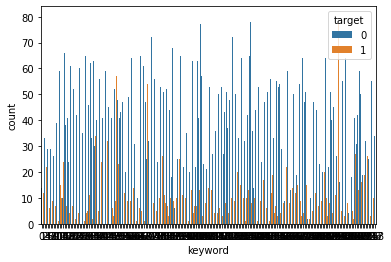

In [22]:
sns.countplot(x='keyword', hue='target', data=data)

## Model building

In [23]:
# dropping irrelevant columns
data.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
data.head()

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


In [25]:
from tensorflow import keras
from keras.preprocessing.text import Tokenizer

In [26]:
x = data['text']
y = data['target']

In [27]:
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(x)
len(tokenizer.word_index)
dict_size = len(tokenizer.word_index)+1
print(dict_size)

30730


In [29]:
from keras.preprocessing.sequence import pad_sequences

encoded_seq = tokenizer.texts_to_sequences(x)
final_input = pad_sequences(encoded_seq, maxlen=200, padding='pre')
final_output = y

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SpatialDropout1D, Dropout

In [31]:
dim = 32
model = Sequential()
model.add(Embedding(dict_size, dim, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(120, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(40))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           983360    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200, 50)           16600     
_________________________________________________________________
dropout (Dropout)            (None, 200, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 120)          82080     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 120)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                2

In [34]:
prediction = model.fit(final_input, final_output, epochs=3, batch_size=32)

Epoch 1/3
356/356 [==============================] - 191s 536ms/step - loss: 0.1815 - accuracy: 0.9338
Epoch 2/3
356/356 [==============================] - 191s 537ms/step - loss: 0.1632 - accuracy: 0.9417
Epoch 3/3
356/356 [==============================] - 191s 538ms/step - loss: 0.1466 - accuracy: 0.9472


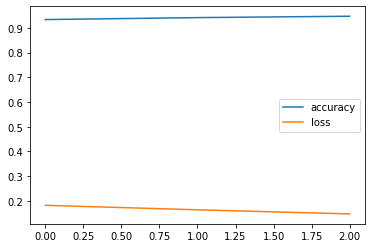

In [36]:
plt.plot(prediction.history['accuracy'],label='accuracy')
plt.plot(prediction.history['loss'], label='loss')
plt.legend(loc='best')
plt.show()

In [37]:
model.save("Disaster predictor.h5")

## Prediction on random output

In [38]:
def predict_disaster(tweet):
  l = []
  l.append(tweet)
  sequence = tokenizer.texts_to_sequences(l)
  pad_seq = pad_sequences(sequence, maxlen=80, padding='pre')
  output = model.predict_classes(pad_seq)

  if int(output.round().item()) == 1:
    print("True, its a true news after disaster.")
  else:
    print('THis is a false news related to disaster.')

In [39]:
predict_disaster("Communal violence in India")

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


THis is a false news related to disaster.
